In [1]:
#!pip3 install opencv-python
#!pip install pafy -U
#!pip install youtube_dl

In [2]:
#!pip install ipydagred3
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager
# 

In [3]:
# fix dislike count problem
#!pip uninstall -y pafy
#!pip install git+https://github.com/Cupcakus/pafy

In [4]:
#!pip install ipynb

In [5]:
#!ls -l /home/jovyan/work/images
#!touch /home/jovyan/work/images/test

In [6]:
#!jupyter nbconvert --to python video_actions_v2.ipynb
#!jupyter nbconvert --to python video_download.ipynb
#!jupyter nbconvert --to python video_download_file.ipynb

In [7]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#print("Setup Complete")
#https://stackoverflow.com/questions/66239052/plot-a-seaborn-heatmap-over-a-background-picture
import matplotlib.image as mpimg # add
from io import BytesIO

In [8]:
from ipynb.fs.full.video_actions_v2 import *
#from ipynb.fs.full.coral_actions import *
from ipynb.fs.full.interact_with_app import *
from ipynb.fs.full.box_tool import *

# Coral Actions

## PoseEngineAction

In [9]:
import random
from PIL import Image
from PIL import ImageDraw

from pycoral.utils import edgetpu
from PIL import Image
from tflite_runtime.interpreter import load_delegate
from tflite_runtime.interpreter import Interpreter

import collections
import enum
import math
import numpy as np
import os
import platform
import sys
import time

from projectposenet.pose_engine import PoseEngine

colors = [(255,0,0,255) ,(0,255,0,255) ,(0,0,255,255),(255,255,0,255) ,(0,255,255,255) ,(255,255,255,255), \
         (125,0,0,255) ,(125,255,0,255) ,(125,0,255,255),(125,255,0,255) ,(125,255,255,255) ,(125,255,255,255)]

EDGES = (
    ('nose', 'left eye'),
    ('nose', 'right eye'),
    ('nose', 'left ear'),
    ('nose', 'right ear'),
    ('left ear', 'left eye'),
    ('right ear', 'right eye'),
    ('left eye', 'right eye'),
    ('left shoulder', 'right shoulder'),
    ('left shoulder', 'left elbow'),
    ('left shoulder', 'left hip'),
    ('right shoulder', 'right elbow'),
    ('right shoulder', 'right hip'),
    ('left elbow', 'left wrist'),
    ('right elbow', 'right wrist'),
    ('left hip', 'right hip'),
    ('left hip', 'left knee'),
    ('right hip', 'right knee'),
    ('left knee', 'left ankle'),
    ('right knee', 'right ankle'),
)

# 481x641
class PoseEngineAction(BaseAction):
    def __init__(self):
        self.engine = PoseEngine('projectposenet/models/mobilenet/posenet_mobilenet_v1_075_481_641_quant_decoder_edgetpu.tflite')
        self.result = None
    
    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys():
            self.result = {'image':kwargs['image']}
            image = self._get_image(kwargs['image'])
            poses, inference_time = self.engine.DetectPosesInImage(image)
            self.result = {'poses':poses, 'inference_time':inference_time,'image':kwargs['image']}
            return self.result

In [10]:
from PIL import Image, ImageDraw, ImageFont
import random
colors = [(255,0,0,255) ,(0,255,0,255) ,(0,0,255,255),(255,255,0,255) ,(0,255,255,255) ,(255,255,255,255), \
         (125,0,0,255) ,(125,255,0,255) ,(125,0,255,255),(125,255,0,255) ,(125,255,255,255) ,(125,255,255,255)]

class Pose:
    def __init__(self, pose, minScoreKeypoint=-1):
        self.pose = pose
        self.xys = self.get_xys(pose, minScoreKeypoint)
        
    def get_xys(self,pose, min_score=-1):
        xys = {}
        for label, keypoint in pose.keypoints.items():
            score =  float(keypoint.score)
            if score < min_score: continue
            kp_y = int((keypoint.point.y) )
            kp_x = int((keypoint.point.x) )
            xys[label] = (kp_x, kp_y, score)
        return xys            
        
    def addPointsText(self,img,keys,color,r,fontsize):
        for key in keys:
            if key in self.xys:
                x = self.xys[key][0]
                y = self.xys[key][1]
                img.drawPoint( x,y,r,color)
                img.drawText(str(key), x,y,fontsize, color=color)
                
    def addSkeleton(self,img,EDGES,color='red',width=1):
        for a, b in EDGES:
            if a not in self.xys or b not in self.xys: continue
            ax, ay = self.xys[a][0],self.xys[a][1]
            bx, by = self.xys[b][0],self.xys[b][1]
            img.drawLine(ax,ay,bx,by,color=color,width=width)
                
    def printPose(self,mninScorePose=-0.1, minScoreKeypoint=-0.1):
        #if self.pose.score < mninScorePose : continue
        print('\nPose Score: ', self.pose.score)
        for label, keypoint in self.pose.keypoints.items():
            if keypoint.score < minScoreKeypoint : continue
            print(' %-20s x=%-4d y=%-4d score=%.2f' %
                (label, keypoint.yx[1], keypoint.yx[0], keypoint.score))


## DrawPoseAction

In [11]:

                  
class DrawPoseAction(BaseAction):
    def __init__(self):
        self.result = None
    
    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys() and 'poses' in kwargs.keys() :
            image = kwargs['image']
            poses = kwargs['poses']
            self.drawPosePoints(image,poses,EDGES) 
            self.addSkeletons(image,poses,EDGES)
            self.result = {'image':image}
            return self.result
        else:
            return kwargs                
        
    def drawPoint(self,image,x,y,r,rgba):
        draw = ImageDraw.Draw(image)
        leftUpPoint = (x-r, y-r)
        rightDownPoint = (x+r, y+r)
        twoPointList = [leftUpPoint, rightDownPoint]
        draw.ellipse(twoPointList, fill=rgba)

    def drawPosePoints(self,image,poses,EDGES):    
        for pose in poses:
            #if pose.score < 0.4: continue
            rgba =  random.choice(colors)     
            #print('\nPose Score: ', pose.score)
            xys = {}
            minScoreKeypoint = 0.0
            for label, keypoint in pose.keypoints.items():
                if keypoint.score < minScoreKeypoint : continue
                #print(keypoint.point)
                #drawPoint(image,keypoint.yx[1], keypoint.yx[0],2,rgba)
                self.drawPoint(image,keypoint.point.x,keypoint.point.y,2,rgba)
                #kp_y = int((keypoint.yx[0] ) )
                #kp_x = int((keypoint.yx[1] ) )
                kp_y = int( keypoint.point.y)
                kp_x = int( keypoint.point.x)

                xys[label] = (kp_x, kp_y)
                #print(' %-20s x=%-4d y=%-4d score=%.1f' %
                #      (label, keypoint.yx[1], keypoint.yx[0], keypoint.score))
            #print(xys)

            for a, b in EDGES:
                if a not in xys or b not in xys: continue
                ax, ay = xys[a]
                bx, by = xys[b]
                #dwg.add(dwg.line(start=(ax, ay), end=(bx, by), stroke=color, stroke_width=2))
                draw = ImageDraw.Draw(image)
                draw.line((ax,ay,bx,by), fill=128, width=3)
                #print (ax,ay,bx,b)    
                
    def addSkeletons(self,image,poses,EDGES):
        for pose in poses:   
            _pose = Pose(pose)
            _pose.addSkeleton(image,EDGES,color='red',width=1)

## ObjectsInterpreterAction

In [12]:
import time

from PIL import Image
from PIL import ImageDraw

from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file
from pycoral.utils.edgetpu import make_interpreter

class ObjectsInterpreterAction(BaseAction):
    def __init__(self, score_threshold=0.2):
        self.score_threshold = score_threshold 
        self.filter = []
        self.result = None
        # https://github.com/google-coral/test_data
        # https://coral.ai/models/object-detection/
        self.labels = read_label_file('/home/pi/jupyter/coral/pycoral/test_data/coco_labels.txt')
        self.interpreter = make_interpreter('/home/pi/jupyter/coral/pycoral/test_data/ssd_mobilenet_v2_coco_quant_postprocess_edgetpu.tflite')
        self.interpreter.allocate_tensors()

    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys():
            self.result = {'image':kwargs['image']}
            image = self._get_image(kwargs['image'])
            
            start = time.perf_counter()
            self.interpreter.invoke()
            inference_time = time.perf_counter() - start
            #_, scale = common.set_resized_input(
            #    self.interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))
            _, scale = common.set_resized_input(self.interpreter, image.size, lambda size: image)
            
            # https://coral.ai/docs/reference/py/pycoral.adapters/#module-pycoral.adapters.detect
            # A list of Object objects, which each contains the detected object’s id, score, and bounding box as BBox.
            objs = detect.get_objects(self.interpreter,self.score_threshold, scale)
    
            if len(self.filter) > 0: 
                objs = self.filter_objects(objs)
    
            self.result = {'objects':objs, 'inference_time':inference_time,'image':kwargs['image']}
            return self.result
        
    def filter_objects(self,objs):
        objs2 = []
        for obj in objs:
            _label = self.labels.get(obj.id, obj.id) 
            if _label in self.filter:
                objs2.append(obj)
        return objs2        
        
    def input_size(self):
        return common.input_size(self.interpreter)
    
    
    def get_labels(self,objs): 
        _labels = []
        for obj in objs:
            _label = self.labels.get(obj.id, obj.id)   
            if _label not in _labels:
                _labels.append(_label)
        return _labels
            
    def printData(self,objs):        
        for obj in objs:
            print(labels.get(obj.id, obj.id))
            print('  id:    ', obj.id)
            print('  score: ', obj.score)
            print('  bbox:  ', obj.bbox)    

## DrawObjectsAction

In [13]:
class DrawObjectsAction(BaseAction):
    def __init__(self):
        self.result = None
        self.labels = read_label_file('/home/pi/jupyter/coral/pycoral/test_data/coco_labels.txt')
    
    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys() and 'objects' in kwargs.keys() :
            image = kwargs['image'].copy()
            objs = kwargs['objects']
            self.draw_objects(ImageDraw.Draw(image), objs, self.labels)        
            #self.result = {'image':image}
            self.result = dict(kwargs)
            self.result['image'] = image
            return self.result
        else:
            return kwargs                
        
    def draw_objects(self,draw, objs, labels):
        for obj in objs:
            bbox = obj.bbox
            draw.rectangle([(bbox.xmin, bbox.ymin), (bbox.xmax, bbox.ymax)],
                           outline='red')
            draw.text((bbox.xmin + 10, bbox.ymin + 10),
                      '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
                      fill='red')

    def get_labels(self,objs): 
        _labels = []
        for obj in objs:
            _label = self.labels.get(obj.id, obj.id)   
            if _label not in _labels:
                _labels.append(_label)
        return _labels
            
    def printData(self,objs):        
        for obj in objs:
            print(labels.get(obj.id, obj.id))
            print('  id:    ', obj.id)
            print('  score: ', obj.score)
            print('  bbox:  ', obj.bbox)

## SemanticSegmentationAction

In [14]:
#semantic_segmentation.py

import numpy as np
from PIL import Image

from pycoral.adapters import common
from pycoral.adapters import segment
from pycoral.utils.edgetpu import make_interpreter


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  indices = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((indices >> channel) & 1) << shift
    indices >>= 3

  return colormap

def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


class SemanticSegmentationAction(BaseAction):
    def __init__(self):
        self.result = None
        self.interpreter = make_interpreter('/home/pi/jupyter/coral/pycoral/test_data/deeplabv3_mnv2_pascal_quant_edgetpu.tflite', device=':0')
        self.interpreter.allocate_tensors()
        self.width, self.height = common.input_size(self.interpreter)

    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys():
            self.result = {'image':kwargs['image']}
            image = self._get_image(kwargs['image'])
            
            keep_aspect_ratio = True
            if keep_aspect_ratio:
                resized_img, _ = common.set_resized_input(
                self.interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))
            else:
                resized_img = image.resize((self.width, self.height), Image.ANTIALIAS)
                common.set_input(self.interpreter, resized_img)

            self.interpreter.invoke()
            result = segment.get_output(self.interpreter)
            if len(result.shape) == 3:
                result = np.argmax(result, axis=-1)

            # If keep_aspect_ratio, we need to remove the padding area.
            new_width, new_height = resized_img.size
            result = result[:new_height, :new_width]
            mask_img = Image.fromarray(label_to_color_image(result).astype(np.uint8))

            # Concat resized input image and processed segmentation results.
            output_img = Image.new('RGB', (2 * new_width, new_height))
            output_img.paste(resized_img, (0, 0))
            output_img.paste(mask_img, (self.width, 0))
  
            self.result = {'image':output_img}
            return self.result

## ObjectsInterpreterWidget

In [15]:
class ObjectsInterpreterWidget(BaseWidget):
    def __init__(self, action=None, imageWidget=None, parent=None):
        self.action = action
        self.parent = parent
        self.result = None
        self.imageWidget = imageWidget
        #self.threshold   = widgets.Text(description = 'threshold' , value=str(self.parent.action.score_threshold), style=style, layout=layout2)
        self.threshold   = widgets.Text(description = 'threshold' , value=str(self.action.score_threshold), style=style, layout=layout2)
        self.out  = widgets.Output()
        self.vbox   = widgets.VBox([self.threshold,self.out])
        self.labels = []    
        self.threshold.on_submit(self.on_value_submit_threshold)    
            
    def evaluate(self, **kwargs):   
        self.kwargs=kwargs
        self.result = self.action.evaluate(**kwargs)
        if isinstance(self.result, dict):
             with self.out:
                clear_output()
                _labels = self.action.get_labels(self.result['objects'])
                self.labels = []  
                for _label in _labels:
                    _checkbox = widgets.Checkbox(description=_label,value=True)
                    _checkbox.observe(self.label_on_change,'value')
                    display(_checkbox)     
                    self.labels.append(_checkbox)
        return self.result
    
    def on_value_submit_threshold(self,change):
        self.action.score_threshold = float(change.value)
        self.result = self.action.evaluate(**self.kwargs)
        #self.evaluate_subchain()
        
    def evaluate_subchain(self):    
        parent_result = self.parent.evaluate(**self.parent.parent.result)
        self.evaluate(**parent_result)
        self.imageWidget.evaluate(self.result['image'])
        
    def label_on_change(self,change):  
        if change['type'] == 'change' and change['name'] == 'value':
            #print(change['name'])
            _labels = []
            for _label in self.labels:
                if _label.value == True:
                    _labels.append(_label.description)
            print(_labels)
            self.parent.action.filter = _labels
            self.evaluate_subchain()
            #K

# Coral Actions 2

## CountPoseAction

In [16]:
class CountPoseAction(BaseAction):
    def __init__(self):
        self.result = None
    
    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys() and 'poses' in kwargs.keys() :
            image = kwargs['image']
            poses = kwargs['poses']
            self.drawPosePoints(image,poses,EDGES) 
            self.addSkeletons(image,poses,EDGES)
            self.result = {'image':image}
            self.result['count']= len(poses)
            self.result['poses']=poses
            Bboxes=[]
            ScoreRanges=[]
            for pose in poses:
                Bboxes.append(self.calculateBbox(pose))
                ScoreRanges.append(self.calculateScoreRange(pose))
            self.result['bboxes']=Bboxes
            self.result['score_range']=ScoreRanges
            return self.result
        else:
            return kwargs                
        
    def drawPoint(self,image,x,y,r,rgba):
        draw = ImageDraw.Draw(image)
        leftUpPoint = (x-r, y-r)
        rightDownPoint = (x+r, y+r)
        twoPointList = [leftUpPoint, rightDownPoint]
        draw.ellipse(twoPointList, fill=rgba)
        
    def addSkeletons(self,image,poses,EDGES):
        for pose in poses:   
            _pose = Pose(pose)
            _pose.addSkeleton(image,EDGES,color='red',width=1)

    def drawPosePoints(self,image,poses,EDGES):    
        for pose in poses:
            #if pose.score < 0.4: continue
            rgba =  random.choice(colors)     
            #print('\nPose Score: ', pose.score)
            xys = {}
            minScoreKeypoint = 0.0
            for label, keypoint in pose.keypoints.items():
                if keypoint.score < minScoreKeypoint : continue
                #print(keypoint.point)
                #drawPoint(image,keypoint.yx[1], keypoint.yx[0],2,rgba)
                self.drawPoint(image,keypoint.point.x,keypoint.point.y,2,rgba)
                #kp_y = int((keypoint.yx[0] ) )
                #kp_x = int((keypoint.yx[1] ) )
                kp_y = int( keypoint.point.y)
                kp_x = int( keypoint.point.x)

                xys[label] = (kp_x, kp_y)
                #print(' %-20s x=%-4d y=%-4d score=%.1f' %
                #      (label, keypoint.yx[1], keypoint.yx[0], keypoint.score))
            #print(xys)

            for a, b in EDGES:
                if a not in xys or b not in xys: continue
                ax, ay = xys[a]
                bx, by = xys[b]
                #dwg.add(dwg.line(start=(ax, ay), end=(bx, by), stroke=color, stroke_width=2))
                draw = ImageDraw.Draw(image)
                draw.line((ax,ay,bx,by), fill=128, width=3)
                #print (ax,ay,bx,b)     
                
    def calculateBbox(self,pose):

        minimum=[9999999,9999899]
        maximum=[0,0]
        for label, keypoint in pose.keypoints.items():

                print(keypoint.point)
                #drawPoint(image,keypoint.yx[1], keypoint.yx[0],2,rgba)

                #kp_y = int((keypoint.yx[0] ) )
                #kp_x = int((keypoint.yx[1] ) )
                kp_y = int( keypoint.point.y)
                kp_x = int( keypoint.point.x)
                if kp_x<minimum[0]:
                    minimum[0]=kp_x
                if kp_x>maximum[0]:
                    maximum[0]=kp_x
                if kp_y<minimum[1]:
                    minimum[1]=kp_y
                if kp_y>maximum[1]:
                    maximum[1]=kp_y

        return minimum,maximum 
    
    def calculateScoreRange(self,pose):

        minimum=9999999
        maximum=0
        for label, keypoint in pose.keypoints.items():

            
                score = keypoint.score
                
                if score<minimum:
                    minimum=score
                if score>maximum:
                    maximum=score
                

        return minimum,maximum                

## CountObjectsAction

In [17]:
class CountObjectsAction(BaseAction):
    def __init__(self):
        self.result = None
        self.labels = read_label_file('/home/pi/jupyter/coral/pycoral/test_data/coco_labels.txt')
    
    def evaluate1(self, **kwargs):  
        if  'objects' in kwargs.keys() :
            objs = kwargs['objects'] 
            _count=self.count(objs)
            self.result = dict(kwargs)
            self.result['count']=_count
            return self.result
        else:
            return kwargs  
        
        
    def evaluate(self, **kwargs):        
        if 'image' in kwargs.keys() and 'objects' in kwargs.keys() :
            image = kwargs['image'].copy()
            objs = kwargs['objects']
            count=self.count(objs)
            self.draw_objects(ImageDraw.Draw(image), objs, self.labels)        
            #self.result = {'image':image}
            self.result = dict(kwargs)
            self.result['image'] = image
            self.result['count']= count
            return self.result
        else:
            return kwargs     
        
    def count(self,objects):    
        counter=0
        for object in objects:
            if object.id==0:
                counter=counter+1
        return counter


        
    def draw_objects(self,draw, objs, labels):
        for obj in objs:
            bbox = obj.bbox
            draw.rectangle([(bbox.xmin, bbox.ymin), (bbox.xmax, bbox.ymax)],
                           outline='red')
            draw.text((bbox.xmin + 10, bbox.ymin + 10),
                      '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
                      fill='red')

    def get_labels(self,objs): 
        _labels = []
        for obj in objs:
            _label = self.labels.get(obj.id, obj.id)   
            if _label not in _labels:
                _labels.append(_label)
        return _labels
            
    def printData(self,objs):        
        for obj in objs:
            print(labels.get(obj.id, obj.id))
            print('  id:    ', obj.id)
            print('  score: ', obj.score)
            print('  bbox:  ', obj.bbox)

## CountObjectsWidget

In [18]:
layout2={'width': '350px'}

class CountObjectsWidget(BaseWidget):
    def __init__(self, action=None, imageWidget=None, parent=None):
        self.action = action
        self.parent = parent
        self.result = None
        self.count = widgets.Text(description = 'c', style=style, layout=layout2)
        self.imageWidget = imageWidget
        self.vbox   = widgets.VBox([self.count])
            
    def evaluate(self, **kwargs):     
        self.result = self.action.evaluate(**kwargs)
        if  'count' in self.result.keys() :
            self.count.value=str (self.result['count'])
        return self.result

# Applications

In [19]:
#_app = SimpleApplicationWidget(filename = '_EasyVideoPipeLine_641_481.json')
_app = SimpleApplicationWidget(filename = '_EasyVideoPipeLine_641_481_Squad.json')
_app._tab.displayWidget.skipframes.value='0'
_app._tab.displayWidget.action.skipframes=0
addTemplateWrapperTab(_app,TemplateWrapperWidget,PoseEngineAction()) 
addTemplateWrapperTab(_app,CountObjectsWidget,CountPoseAction()) 
_app._tab.on_select({'new':1})

Output()

LiveVideoSourcesWidget
init_video
init_video None
<Task pending name='test' coro=<HaltableActionExecutor.my_code() running at /home/pi/jupyter/scray/projects/edge/coral/actions/video_actions_v2.ipynb:1565>>


In [20]:
#app=_app
#_keypoints=app._tab._widgets[4].result['poses'][0].keypoints
#_score=app._tab._widgets[4].result['poses'][0].score
#PoseBox(keypoints=[_keypoints,_score])

## Bilder aus Videos ##

In [21]:
#save image
app._tab.displayWidget.image['image'].save('/home/pi/images/images' + _id + '_' + str(_action.index) + '_' +str(_action.frame_count)+ '.png')

NameError: name 'app' is not defined

### Dataframe aus Pipeline ##

In [22]:
# Frames skip
def next_step(app=None,skipframes=None,action=None): #Problem: wird doppelt ausgeführt?!
    _out=widgets.Output()
    with _out:
        #app._tab.displayWidget.action.skipframes=skipframes   -> Line die die Kernel-Crashs verursacht hat?!                                     #356 für Squat
        app._tab.displayWidget.skipframes.value = str(skipframes)
        _result = app._tab.evaluateWidgetActionList(image=None, start=1, end=None)
        _image=app._tab._widgets[1].result['image']
        return _image,_action.frame_count,_result

#Dataframe aus Pipeline
def bbox_to_grid(bbox=None,min=(0,0),max=None, size=(162, 181), black=(211,0)):
    org_size=(641 - black[0],481  - black[1])
    factor = size[0] / org_size[0], size[1] / org_size[1]
    margin = (round(black[0]/2), round(black[1]/2))
    return (round((bbox[0][0] - margin[0]) * factor[0] ) + min[0], round(bbox[0][1] * factor[1])+ min[1]) ,  (round((bbox[1][0] - margin[0]) * factor[0] )+ min[0],  round(bbox[1][1] * factor[1])+ min[1])    

def add_poses_to_dataframe_pipeline(df,_key,_poses,size=(1280,720),black=None,min=(0,0),max=(1279,719)): 
    for _pose in _poses:
        #_time = time.localtime(_pose.time_seconds)
        #print(_pose.bbox)
        _grid_box = bbox_to_grid(bbox=_pose.bbox,min=_pose.min,max=_pose.max,size=size,black=black)
        org_pose_bbox=((_pose.bbox[0][0],_pose.bbox[0][1]),(_pose.bbox[1][0],_pose.bbox[1][1]))
        df.loc[len(df.index)] = [_key,_pose.size,(_pose.min,_pose.max),org_pose_bbox,_pose.pose.score,_grid_box, None,_pose]

def empty_poses_dataframe_pipeline():     
    df = pd.DataFrame(columns = ['key','size','grid_box','org_grid_box','score', 'bbox','framecount','pose' ])
    return df

def dataframe_aus_pipeline(app=None,image=None,black=None):
    _keypoints=app._tab._widgets[4].result['poses'][0].keypoints
    _bbox=app._tab._widgets[4].result['bboxes'][0]
    _score=app._tab._widgets[4].result['poses'][0].score
    _poses=[PoseBox(keypoints=[_keypoints,_score],bbox=_bbox,min=(0,0),max=(1280,720))]
    df=empty_poses_dataframe_pipeline()
    add_poses_to_dataframe_pipeline(df,'Sport',_poses,black=black)
    return df

### Box resize ##

### Squaterkennung ##

In [23]:
def resizeSkeletonPoint(point=None,min=(0,0),max=None, size=(162, 181), black=(211,0)):
    size_x = max[0] - min[0]
    size_y = max[1] - min[1]
    org_size=(641 - black[0],481  - black[1])
    factor = size[0] / org_size[0], size[1] / org_size[1]
    margin = (round(black[0]/2), round(black[1]/2))
    return (round((point[0] - margin[0]) * factor[0] ) + min[0], round(point[1] * factor[1])+ min[1]) 


In [24]:
def get_resized_SkeletonPoints(self,names=None,min=None,max=None,size=None,black=None): #spart quasi Schreibarbeit
    points=[]
    for name in names:
        points.append(resizeSkeletonPoint(point=self.xys[name],min=min,max=max,size=size,black=black))
    return points

In [25]:
def addSkeletonSquat(self,pose=None, color='red',width=1,min=(0,0),max=None,size=None,black=None): #nur für einzelne Keypoints
    self.xys = self.get_xys(pose=pose)
    
    points=get_resized_SkeletonPoints(self,names=['right shoulder','right ankle','right knee','right hip'],min=min,max=max,size=size,black=black)
    
    #resizeSkeletonPoint(point=self.xys['right shoulder'],min=min,max=max,size=size,black=black),
    #resizeSkeletonPoint(point=self.xys['right ankle'],min=min,max=max,size=_size,black=_black),
    #resizeSkeletonPoint(point=self.xys['right knee'],min=min,max=max,size=_size,black=_black),
    #resizeSkeletonPoint(point=self.xys['right hip'],min=min,max=max,size=_size,black=_black)
            
    self.drawLine(points[0][0],points[0][1],points[3][0],points[3][1],color=color,width=width)
    self.drawLine(points[3][0],points[3][1],points[2][0],points[2][1],color=color,width=width)
    self.drawLine(points[2][0],points[2][1],points[1][0],points[1][1],color=color,width=width)  
    #print(self.xys['left shoulder'][2])

def draw_skeleton_points(self,image_tool=None,pose=None, color='blue',width=3,min=(0,0),max=None,size=None,black=None):
    points=get_resized_SkeletonPoints(self,names=KEYPOINTS,min=min,max=max,size=size,black=black)
    for point in points:
        image_tool.drawPoint(point[0],point[1],width,color)
    

In [41]:
def main(app=None,skipframes=None,action=None): #Aufrufe der Funktionen
    image,framecount,result=next_step(app=app,skipframes=skipframes,action=action)
    _crop_image = app._tab.evaluateWidgetActionList(end=2, image=app._tab.displayWidget.image  )['image']       
    _black = app._tab._widgets[2].action.black_area_size(image=_crop_image)  
    df=dataframe_aus_pipeline(app=app,image=image,black=_black)
    _size=image.size
    
    _box = bbox_to_grid(bbox=df.iloc[0]['org_grid_box'],min=(0,0),max=(1280,720), size=_size, black=_black)
    image_tool=PoseImageTool(image=image)
    image_tool.drawBBox(_box,color='green',width=1)
    _rowb=df.iloc[0]
    
    addSkeletonSquat(image_tool,pose=_rowb['pose'].pose, color='red',width=1,min=_rowb['pose'].min,max=_rowb['pose'].max,size=_size,black=_black)
    draw_skeleton_points(image_tool,image_tool=image_tool,pose=_rowb['pose'].pose, color='blue',width=3,min=_rowb['pose'].min,max=_rowb['pose'].max,size=_size,black=_black)
    return image_tool,framecount,_rowb,_size,_black ###########


In [38]:
_id=_app._tab._widgets[0].action.id 
_action=_app._tab.displayWidget.action

62


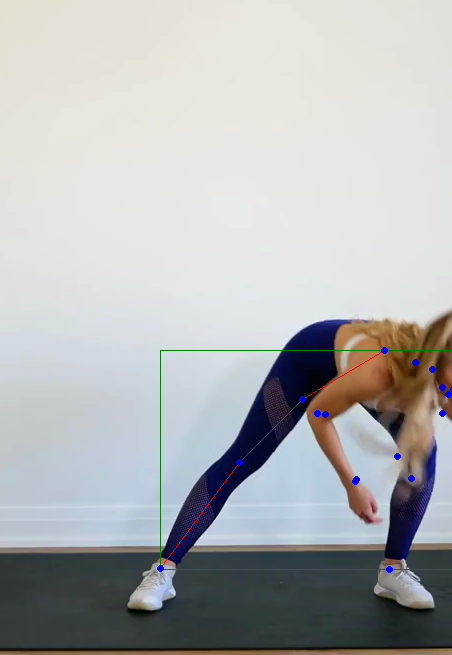

64


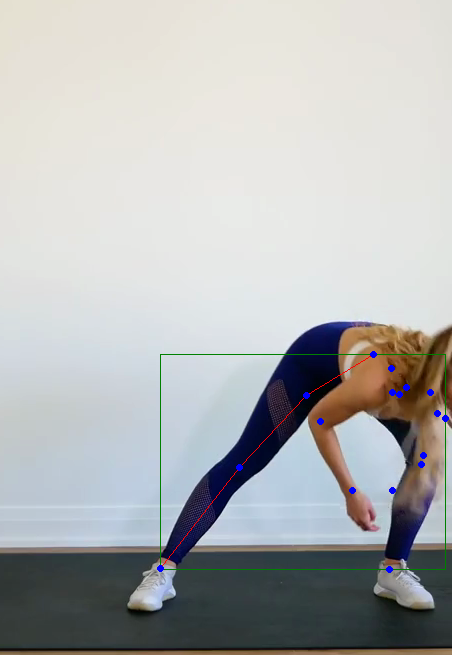

66


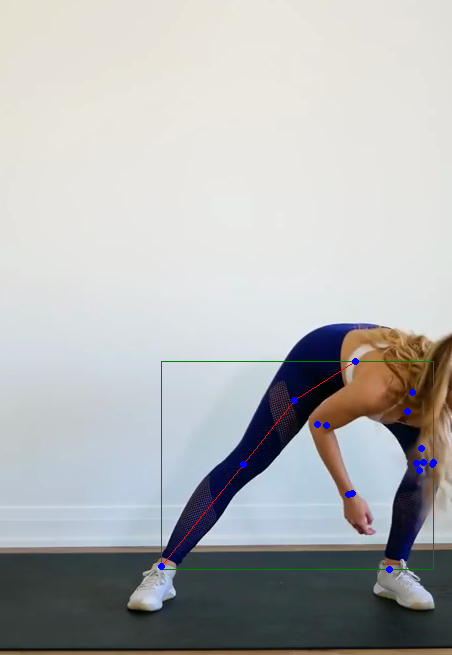

68


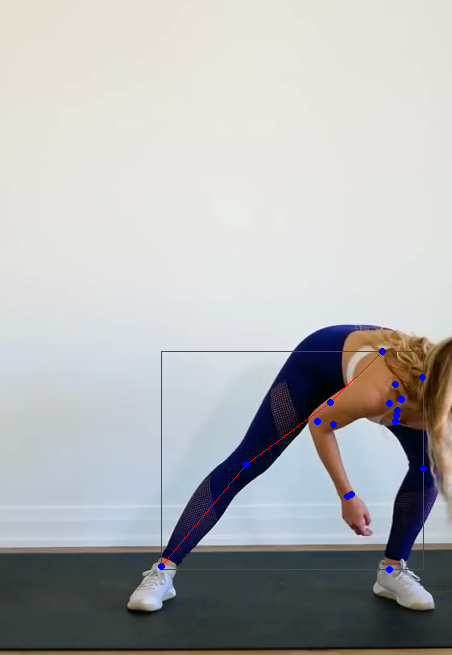

70


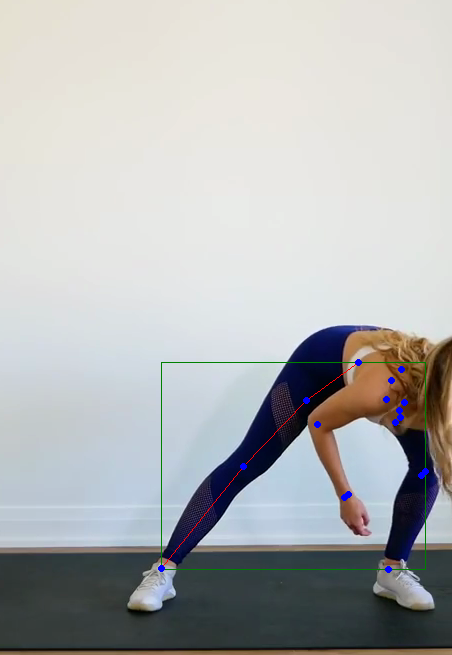

72


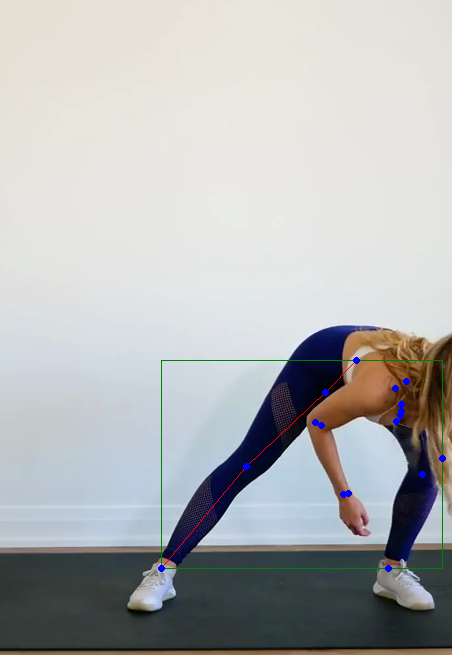

74


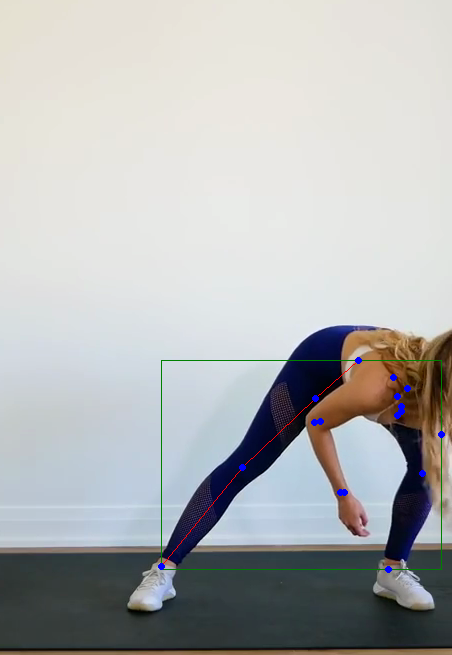

76


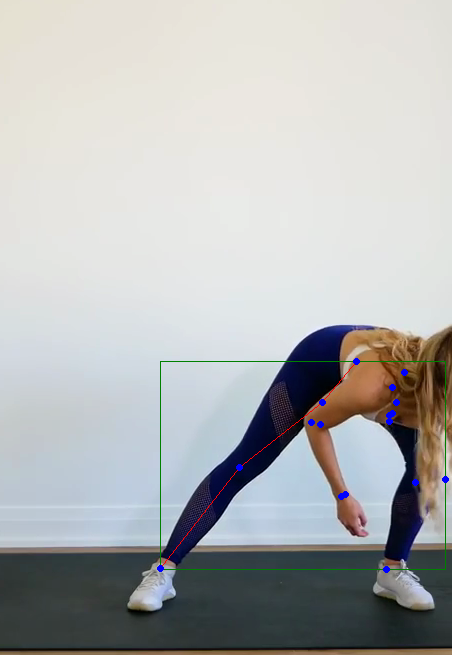

78


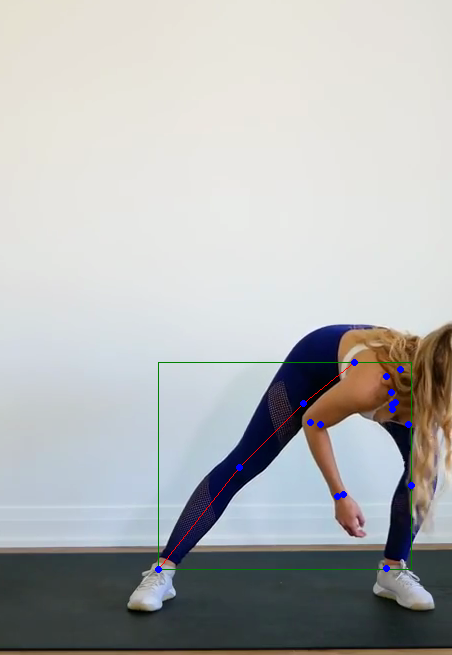

80


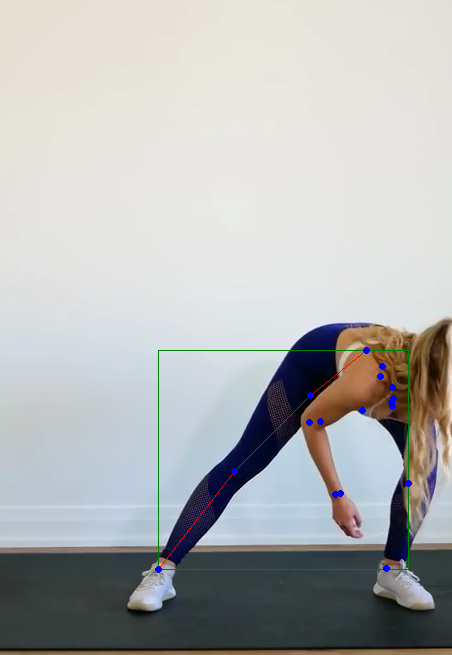

In [42]:
for i in range(0,10):
   
    image_tool,framecount,_rowb,_size,_black=main(app=_app,skipframes=10,action=_action) #F 818
    print(framecount)
    display(image_tool.image)
    image_tool.image.save('/home/pi/images/images' + _id + '_' + str(_action.index) + '_' +str(framecount)+ '.png') #funktioniert nicht
    #image_tool.image

In [44]:
def standing(self,pose=None,width=1,min=(0,0),max=None,size=None,black=None): #aufrecht stehend ?
    self.xys = self.get_xys(pose=pose)
    truth=0
    
    points=get_resized_SkeletonPoints(self,names=['right shoulder','right ankle','right knee','right hip'],min=min,max=max,size=size,black=black)
    #rechts links beachten->Score(dritter Wert)
    vshx=points[3][0]-points[0][0] # v schulter zu Hüfte
    vshy=points[3][1]-points[0][1]
    
    vhkx=points[2][0]-points[3][0]# v Hüfte zu Knie
    vhky=points[2][1]-points[3][1]
    
    vkkx=points[1][0]-points[2][0]# v Knie zu Knöchel
    vkky=points[1][1]-points[2][1]
    
    factorshhk=vshy/vhky #um die Vektoren Schulter zu Hüfte und Hüfte zu Knie
    vhkyresized=vhky*factorshhk
    vhkxresized=vhkx*factorshhk
    
    xdiff=vshx-vhkxresized
    ydiff=vshy-vhkyresized #kontrolle, ydiff müsste 0 betragen
    
    xdiff=abs(xdiff)
    #print(ydiff)
    #print(xdiff)
   
    if xdiff<=50: #referenzwerte vom Aufrechtstehen raussuchen (Frame 763) (40)
        truth=truth+2
    if 50<xdiff<60:#größere Zahl bis wohin die Abweichung noch vertretbar ist (Frame 729) 60 
        truth=truth+1
    if xdiff>60:#entsprechende Zahl???
        truth=truth-10
        

    factorhkkk=vhky/vkky #um die Vektoren Hüfte zu Knie und Knie zu Knöchel
    vkkyresized=vkky*factorhkkk
    vkkxresized=vkkx*factorhkkk
    
    xdiff1=vhkx-vkkxresized
    ydiff1=vhky-vkkyresized #kontrolle, ydiff müsste 0 betragen
    
    xdiff1=abs(xdiff1)
    #print(xdiff1)
    
    if xdiff1<=20: #referenzwerte vom Aufrechtstehen raussuchen oder 15 F763
        truth=truth+2
    if 20<xdiff1<50: #größere Zahl bis wohin die Abweichung noch vertretbar ist kleiner 84 !
        truth=truth+1
    if xdiff1>50: #entsprechende Zahl
        truth=truth-10
    
    if(truth>=2):
        print('Standing')
        print(truth)
        return True
    else:
        print(truth)
        return False
  

In [47]:
#standing(_image_tool,pose=_rowb['pose'].pose, width=1,min=_rowb['pose'].min,max=_rowb['pose'].max,size=_size,black=_black) alt
#_rowb=df.iloc[0] # oder in Funktion als return übergeben
#_size=_image.size
standing(image_tool,pose=_rowb['pose'].pose, width=1,min=_rowb['pose'].min,max=_rowb['pose'].max,size=_size,black=_black) #standing muss in die Schleife, damit es für jedes der Bilder bestimmt wird

Standing
4


True

In [48]:
def betragVektor(x,y): #x und y sind die jeweiligen Komponenten des Vektors
    #print(x,y)
    x=x*x
    y=y*y
    #print(x,y)
    return math.sqrt(x+y)

In [52]:
#distanceStanding=0
def vergleichswert(self,pose=None,width=1,min=(0,0),max=None,size=None,black=None): #Optimierung: nicht nur ein Wert sondern Mittelwert nehmen
    self.xys = self.get_xys(pose=pose)
    points=get_resized_SkeletonPoints(self,names=['right shoulder','right ankle','right knee','right hip'],min=min,max=max,size=size,black=black)
    vshx=points[3][0]-points[0][0]
    vshy=points[3][1]-points[0][1]
    #print(vshx,vshy)
    if standing(image_tool,pose=_rowb['pose'].pose, width=1,min=_rowb['pose'].min,max=_rowb['pose'].max,size=_size,black=_black)==True: #?
        distanceStanding=betragVektor(vshx,vshy)
        return distanceStanding 
    return None

In [53]:
dS=vergleichswert(image_tool,pose=_rowb['pose'].pose, width=1,min=_rowb['pose'].min,max=_rowb['pose'].max,size=_size,black=_black)

Standing
4


In [54]:
#dS
#Frame 754: 145
dS=125

In [55]:
def squat(self,pose=None,width=1,min=(0,0),max=None,size=None,black=None,dS=None):
    self.xys = self.get_xys(pose=pose)
    score=0
   
    #points=resizeSkeletonPoint(point=self.xys['right shoulder'],min=min,max=max),resizeSkeletonPoint(point=self.xys['right ankle'],min=min,max=max),resizeSkeletonPoint(point=self.xys['right knee'],min=min,max=max),resizeSkeletonPoint(point=self.xys['right hip'],min=min,max=max)
    points=get_resized_SkeletonPoints(self,names=['right shoulder','right ankle','right knee','right hip'],min=min,max=max,size=size,black=black)
    vshx=points[3][0]-points[0][0] # v schulter zu Hüfte
    vshy=points[3][1]-points[0][1]
    
    vhkx=points[2][0]-points[3][0]# v Hüfte zu Knie
    vhky=points[2][1]-points[3][1]
    
    vkkx=points[1][0]-points[2][0]# v Knie zu Knöchel
    vkky=points[1][1]-points[2][1]
    
    
    #Hüfte tiefer als Knie
    print(vhky)
    
    if vhky<=11: #muss unbedingt erfüllt sein (optional zweite Squatvariante mit Winkel kleiner 90 Grad) Frame 741 oder 362 umgekehrtes Koordinatensystem bedenken!!!
        print('Squat')
        score=score+10 #gesamt Squat Score
    
        #gerader Rücken
        distanceSquat=betragVektor(vshx,vshy) 
        print(distanceSquat) #175 Frame 362
        difference=dS-distanceSquat # zwischen 362 und 754 30 unterschied-> Grenzwert
        print(difference)
        
        if abs(difference)< 30:#Messungenauigkeit bestimmen 
            score=score+10
        if abs(difference)> 30:#Grenzwert einfügen
            print('Rücken strecken')
            
        #Knie nicht zu weit vorne ?
        '''
        
        #Rücken parallel Schienbein

        factorshkk=vshy/vkky #um die Vektoren Schulter zu Hüfte und Knie zu Knöchel
        vkkyresized1=vkky*factorshkk
        vkkxresized1=vkkx*factorshkk

        xdiff2=vshx-vkkxresized
        ydiff2=vshy-vkkyresized #kontrolle, ydiff müsste 0 betragen

        xdiff2abs=abs(xdiff2)
        print(xdiff2)

        if xdiff2abs< #referenzwerte vom Aufrechtstehen raussuchen
            score=score+10
        if 0<xdiff2< #größere Zahl bis wohin die Abweichung noch vertretbar ist
            score=score+5
            print('leicht zurücklehnen')
        if 0>xdiff2> #kleinere Zahl bis wohin die Abweichung noch vertretbar ist
            score=score+5
            print('leicht nach vorne lehnen')
        if >xdiff2 #entsprechende Zahlen einfügen die neg extremwerte
            print('nach vorne lehnen!')
        if <xdiff2 #entsprechende Zahlen einfügen die pos extremwerte
            print('nach hinten lehnen!')

        
        print(score)
        if score==25:
            print('good Squat')
        if score==30:
            print('very good Squat')
        return True
        '''

In [57]:
squat(image_tool,pose=_rowb['pose'].pose, width=1,min=_rowb['pose'].min,max=_rowb['pose'].max,size=_size,black=_black,dS=dS)

76


In [ ]:
#Squatcounter